In [1]:
from utils import *

import pandas as pd
import matplotlib.pylab as plt

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *

import seaborn as sns
sns.despine()

/Users/J/anaconda/envs/dlnd/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
WINDOW = 30
EMB_SIZE = 5
STEP = 1
FORECAST = 30

In [3]:
data_original = pd.read_csv('./data/AAPL1216.csv')[::-1]

openp = data_original['Open'].tolist()
highp = data_original['High'].tolist()
lowp = data_original['Low'].tolist()
closep = data_original['Adj Close'].tolist()
volumep = data_original['Volume'].tolist()

In [4]:
X, Y = [], []
for i in range(0, len(data_original), STEP): 
    try:
        o = openp[i:i+WINDOW]
        h = highp[i:i+WINDOW]
        l = lowp[i:i+WINDOW]
        c = closep[i:i+WINDOW]
        v = volumep[i:i+WINDOW]

        o = (np.array(o) - np.mean(o)) / np.std(o)
        h = (np.array(h) - np.mean(h)) / np.std(h)
        l = (np.array(l) - np.mean(l)) / np.std(l)
        c = (np.array(c) - np.mean(c)) / np.std(c)
        v = (np.array(v) - np.mean(v)) / np.std(v)

        x_i = closep[i:i+WINDOW]
        y_i = closep[i+WINDOW+FORECAST]  

        last_close = x_i[-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

        x_i = np.column_stack((o, h, l, c, v))

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

In [5]:
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

In [6]:
X.shape

(946, 30, 5)

In [7]:
model = Sequential()

# Layer 1
model.add(Convolution1D(input_shape = (WINDOW, EMB_SIZE),
                        filters=16,
                        kernel_size=4,
                        padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.6))


# Layer 2
model.add(Convolution1D(filters=8,
                        kernel_size=4,
                        padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.6))
model.add(Flatten())

# Layer 3
model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())

# Output Layer
model.add(Dense(2))
model.add(Activation('softmax'))

opt = Nadam(lr=0.002)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="lolkek.hdf5", verbose=1, save_best_only=True)

print(model.summary())

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 30, 16)            336       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 16)            64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30, 16)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 30, 8)             520       
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 8)             32        
___________________________________________________________

In [8]:
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
history = model.fit(X_train, Y_train, 
          epochs = 1500, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.2,
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

Train on 680 samples, validate on 171 samples
Epoch 1/1500
680/680 [==============================] - 1s 2ms/step - loss: 0.8906 - acc: 0.4721 - val_loss: 0.7031 - val_acc: 0.5205

Epoch 00001: val_loss improved from inf to 0.70307, saving model to lolkek.hdf5
Epoch 2/1500
680/680 [==============================] - 0s 58us/step - loss: 0.7726 - acc: 0.5176 - val_loss: 0.6983 - val_acc: 0.5205

Epoch 00002: val_loss improved from 0.70307 to 0.69830, saving model to lolkek.hdf5
Epoch 3/1500
680/680 [==============================] - 0s 57us/step - loss: 0.7624 - acc: 0.4971 - val_loss: 0.7008 - val_acc: 0.5322

Epoch 00003: val_loss did not improve
Epoch 4/1500
680/680 [==============================] - 0s 56us/step - loss: 0.7191 - acc: 0.5500 - val_loss: 0.7039 - val_acc: 0.5263

Epoch 00004: val_loss did not improve
Epoch 5/1500
680/680 [==============================] - 0s 63us/step - loss: 0.7250 - acc: 0.5368 - val_loss: 0.7044 - val_acc: 0.5205

Epoch 00005: val_loss did not impro

Epoch 41/1500
680/680 [==============================] - 0s 61us/step - loss: 0.6151 - acc: 0.6500 - val_loss: 0.6216 - val_acc: 0.6491

Epoch 00041: val_loss improved from 0.62775 to 0.62159, saving model to lolkek.hdf5
Epoch 42/1500
680/680 [==============================] - 0s 65us/step - loss: 0.6203 - acc: 0.6397 - val_loss: 0.6261 - val_acc: 0.6199

Epoch 00042: val_loss did not improve
Epoch 43/1500
680/680 [==============================] - 0s 56us/step - loss: 0.6278 - acc: 0.6279 - val_loss: 0.6236 - val_acc: 0.6374

Epoch 00043: val_loss did not improve
Epoch 44/1500
680/680 [==============================] - 0s 65us/step - loss: 0.6194 - acc: 0.6324 - val_loss: 0.6255 - val_acc: 0.6257

Epoch 00044: val_loss did not improve
Epoch 45/1500
680/680 [==============================] - 0s 58us/step - loss: 0.6178 - acc: 0.6471 - val_loss: 0.6231 - val_acc: 0.6199

Epoch 00045: val_loss did not improve
Epoch 46/1500
680/680 [==============================] - 0s 58us/step - loss: 0


Epoch 00083: val_loss did not improve
Epoch 84/1500
680/680 [==============================] - 0s 64us/step - loss: 0.6009 - acc: 0.6603 - val_loss: 0.5938 - val_acc: 0.6433

Epoch 00084: val_loss did not improve
Epoch 85/1500
680/680 [==============================] - 0s 57us/step - loss: 0.5869 - acc: 0.6735 - val_loss: 0.5895 - val_acc: 0.6550

Epoch 00085: val_loss did not improve
Epoch 86/1500
680/680 [==============================] - 0s 59us/step - loss: 0.5817 - acc: 0.6838 - val_loss: 0.5896 - val_acc: 0.6667

Epoch 00086: val_loss did not improve
Epoch 87/1500
680/680 [==============================] - 0s 56us/step - loss: 0.5818 - acc: 0.6632 - val_loss: 0.5855 - val_acc: 0.6725

Epoch 00087: val_loss did not improve
Epoch 88/1500
680/680 [==============================] - 0s 56us/step - loss: 0.5687 - acc: 0.6956 - val_loss: 0.5841 - val_acc: 0.6725

Epoch 00088: val_loss improved from 0.58478 to 0.58411, saving model to lolkek.hdf5
Epoch 89/1500
680/680 [=================

Epoch 126/1500
680/680 [==============================] - 0s 70us/step - loss: 0.5397 - acc: 0.7191 - val_loss: 0.5378 - val_acc: 0.7485

Epoch 00126: val_loss improved from 0.54162 to 0.53782, saving model to lolkek.hdf5
Epoch 127/1500
680/680 [==============================] - 0s 86us/step - loss: 0.5535 - acc: 0.7074 - val_loss: 0.5460 - val_acc: 0.7485

Epoch 00127: val_loss did not improve
Epoch 128/1500
680/680 [==============================] - 0s 85us/step - loss: 0.5526 - acc: 0.7324 - val_loss: 0.5520 - val_acc: 0.7135

Epoch 00128: val_loss did not improve
Epoch 129/1500
680/680 [==============================] - 0s 81us/step - loss: 0.5029 - acc: 0.7529 - val_loss: 0.5480 - val_acc: 0.7251

Epoch 00129: val_loss did not improve
Epoch 130/1500
680/680 [==============================] - 0s 76us/step - loss: 0.5322 - acc: 0.7176 - val_loss: 0.5453 - val_acc: 0.7135

Epoch 00130: val_loss did not improve
Epoch 131/1500
680/680 [==============================] - 0s 74us/step - l

680/680 [==============================] - 0s 59us/step - loss: 0.4933 - acc: 0.7603 - val_loss: 0.4995 - val_acc: 0.7602

Epoch 00169: val_loss did not improve
Epoch 170/1500
680/680 [==============================] - 0s 56us/step - loss: 0.4820 - acc: 0.7735 - val_loss: 0.4861 - val_acc: 0.7602

Epoch 00170: val_loss improved from 0.49370 to 0.48610, saving model to lolkek.hdf5
Epoch 171/1500
680/680 [==============================] - 0s 60us/step - loss: 0.4944 - acc: 0.7338 - val_loss: 0.4849 - val_acc: 0.7953

Epoch 00171: val_loss improved from 0.48610 to 0.48494, saving model to lolkek.hdf5
Epoch 172/1500
680/680 [==============================] - 0s 62us/step - loss: 0.4626 - acc: 0.7676 - val_loss: 0.4955 - val_acc: 0.7661

Epoch 00172: val_loss did not improve
Epoch 173/1500
680/680 [==============================] - 0s 57us/step - loss: 0.4976 - acc: 0.7441 - val_loss: 0.4878 - val_acc: 0.7485

Epoch 00173: val_loss did not improve
Epoch 174/1500
680/680 [===================

680/680 [==============================] - 0s 57us/step - loss: 0.4662 - acc: 0.7603 - val_loss: 0.4544 - val_acc: 0.7953

Epoch 00213: val_loss did not improve
Epoch 214/1500
680/680 [==============================] - 0s 56us/step - loss: 0.4515 - acc: 0.7809 - val_loss: 0.4605 - val_acc: 0.7778

Epoch 00214: val_loss did not improve
Epoch 215/1500
680/680 [==============================] - 0s 58us/step - loss: 0.4706 - acc: 0.7544 - val_loss: 0.4552 - val_acc: 0.7836

Epoch 00215: val_loss did not improve
Epoch 216/1500
680/680 [==============================] - 0s 56us/step - loss: 0.4516 - acc: 0.7868 - val_loss: 0.4535 - val_acc: 0.7953

Epoch 00216: val_loss did not improve
Epoch 217/1500
680/680 [==============================] - 0s 61us/step - loss: 0.4560 - acc: 0.7794 - val_loss: 0.4633 - val_acc: 0.7661

Epoch 00217: val_loss did not improve
Epoch 218/1500
680/680 [==============================] - 0s 60us/step - loss: 0.4541 - acc: 0.7779 - val_loss: 0.4617 - val_acc: 0.795

Epoch 258/1500
680/680 [==============================] - 0s 61us/step - loss: 0.3963 - acc: 0.8191 - val_loss: 0.4117 - val_acc: 0.8713

Epoch 00258: val_loss did not improve
Epoch 259/1500
680/680 [==============================] - 0s 56us/step - loss: 0.4309 - acc: 0.7779 - val_loss: 0.4045 - val_acc: 0.8538

Epoch 00259: val_loss did not improve
Epoch 260/1500
680/680 [==============================] - 0s 56us/step - loss: 0.4209 - acc: 0.8103 - val_loss: 0.3959 - val_acc: 0.8596

Epoch 00260: val_loss improved from 0.40446 to 0.39591, saving model to lolkek.hdf5
Epoch 261/1500
680/680 [==============================] - 0s 59us/step - loss: 0.4207 - acc: 0.8000 - val_loss: 0.4044 - val_acc: 0.8480

Epoch 00261: val_loss did not improve
Epoch 262/1500
680/680 [==============================] - 0s 61us/step - loss: 0.4008 - acc: 0.8176 - val_loss: 0.4108 - val_acc: 0.8421

Epoch 00262: val_loss did not improve
Epoch 263/1500
680/680 [==============================] - 0s 59us/step - l

680/680 [==============================] - 0s 63us/step - loss: 0.4077 - acc: 0.8000 - val_loss: 0.3939 - val_acc: 0.8713

Epoch 00303: val_loss did not improve
Epoch 304/1500
680/680 [==============================] - 0s 58us/step - loss: 0.4208 - acc: 0.7882 - val_loss: 0.3942 - val_acc: 0.8480

Epoch 00304: val_loss did not improve
Epoch 305/1500
680/680 [==============================] - 0s 60us/step - loss: 0.4038 - acc: 0.8029 - val_loss: 0.3899 - val_acc: 0.8713

Epoch 00305: val_loss did not improve
Epoch 306/1500
680/680 [==============================] - 0s 57us/step - loss: 0.3849 - acc: 0.8250 - val_loss: 0.3868 - val_acc: 0.8538

Epoch 00306: val_loss did not improve
Epoch 307/1500
680/680 [==============================] - 0s 57us/step - loss: 0.4010 - acc: 0.7897 - val_loss: 0.3821 - val_acc: 0.8596

Epoch 00307: val_loss did not improve
Epoch 308/1500
680/680 [==============================] - 0s 61us/step - loss: 0.3948 - acc: 0.8044 - val_loss: 0.3841 - val_acc: 0.877


Epoch 00348: val_loss did not improve
Epoch 349/1500
680/680 [==============================] - 0s 58us/step - loss: 0.3620 - acc: 0.8338 - val_loss: 0.3778 - val_acc: 0.8830

Epoch 00349: val_loss did not improve
Epoch 350/1500
680/680 [==============================] - 0s 60us/step - loss: 0.3616 - acc: 0.8382 - val_loss: 0.3770 - val_acc: 0.8830

Epoch 00350: val_loss did not improve
Epoch 351/1500
680/680 [==============================] - 0s 57us/step - loss: 0.3693 - acc: 0.8338 - val_loss: 0.3714 - val_acc: 0.8947

Epoch 00351: val_loss did not improve
Epoch 352/1500
680/680 [==============================] - 0s 60us/step - loss: 0.3906 - acc: 0.8103 - val_loss: 0.3652 - val_acc: 0.8889

Epoch 00352: val_loss improved from 0.37101 to 0.36524, saving model to lolkek.hdf5
Epoch 353/1500
680/680 [==============================] - 0s 61us/step - loss: 0.3824 - acc: 0.8221 - val_loss: 0.3611 - val_acc: 0.8830

Epoch 00353: val_loss improved from 0.36524 to 0.36111, saving model to l

680/680 [==============================] - 0s 59us/step - loss: 0.3518 - acc: 0.8353 - val_loss: 0.3640 - val_acc: 0.8830

Epoch 00438: val_loss did not improve
Epoch 439/1500
680/680 [==============================] - 0s 62us/step - loss: 0.3278 - acc: 0.8618 - val_loss: 0.3601 - val_acc: 0.8889

Epoch 00439: val_loss did not improve
Epoch 440/1500
680/680 [==============================] - 0s 56us/step - loss: 0.3733 - acc: 0.8265 - val_loss: 0.3540 - val_acc: 0.8772

Epoch 00440: val_loss did not improve
Epoch 441/1500
680/680 [==============================] - 0s 57us/step - loss: 0.3245 - acc: 0.8544 - val_loss: 0.3511 - val_acc: 0.8713

Epoch 00441: val_loss did not improve
Epoch 442/1500
680/680 [==============================] - 0s 58us/step - loss: 0.3174 - acc: 0.8529 - val_loss: 0.3522 - val_acc: 0.8830

Epoch 00442: val_loss did not improve
Epoch 443/1500
680/680 [==============================] - 0s 56us/step - loss: 0.3601 - acc: 0.8309 - val_loss: 0.3474 - val_acc: 0.888


Epoch 00529: val_loss did not improve
Epoch 530/1500
680/680 [==============================] - 0s 59us/step - loss: 0.3169 - acc: 0.8544 - val_loss: 0.3576 - val_acc: 0.8713

Epoch 00530: val_loss did not improve
Epoch 531/1500
680/680 [==============================] - 0s 56us/step - loss: 0.3227 - acc: 0.8691 - val_loss: 0.3580 - val_acc: 0.8713

Epoch 00531: val_loss did not improve
Epoch 532/1500
680/680 [==============================] - 0s 61us/step - loss: 0.3101 - acc: 0.8676 - val_loss: 0.3564 - val_acc: 0.8830

Epoch 00532: val_loss did not improve
Epoch 533/1500
680/680 [==============================] - 0s 57us/step - loss: 0.3017 - acc: 0.8809 - val_loss: 0.3540 - val_acc: 0.8772

Epoch 00533: val_loss did not improve
Epoch 534/1500
680/680 [==============================] - 0s 57us/step - loss: 0.3112 - acc: 0.8544 - val_loss: 0.3494 - val_acc: 0.8830

Epoch 00534: val_loss did not improve
Epoch 535/1500
680/680 [==============================] - 0s 61us/step - loss: 0.

680/680 [==============================] - 0s 59us/step - loss: 0.3347 - acc: 0.8574 - val_loss: 0.3631 - val_acc: 0.8713

Epoch 00576: val_loss did not improve
Epoch 577/1500
680/680 [==============================] - 0s 58us/step - loss: 0.3012 - acc: 0.8647 - val_loss: 0.3648 - val_acc: 0.8713

Epoch 00577: val_loss did not improve
Epoch 578/1500
680/680 [==============================] - 0s 58us/step - loss: 0.3188 - acc: 0.8618 - val_loss: 0.3606 - val_acc: 0.8655

Epoch 00578: val_loss did not improve
Epoch 579/1500
680/680 [==============================] - 0s 57us/step - loss: 0.3109 - acc: 0.8735 - val_loss: 0.3547 - val_acc: 0.8772

Epoch 00579: val_loss did not improve
Epoch 580/1500
680/680 [==============================] - 0s 59us/step - loss: 0.2937 - acc: 0.8838 - val_loss: 0.3558 - val_acc: 0.8772

Epoch 00580: val_loss did not improve
Epoch 581/1500
680/680 [==============================] - 0s 59us/step - loss: 0.3064 - acc: 0.8750 - val_loss: 0.3490 - val_acc: 0.894

680/680 [==============================] - 0s 63us/step - loss: 0.3205 - acc: 0.8441 - val_loss: 0.3523 - val_acc: 0.8772

Epoch 00621: val_loss did not improve
Epoch 622/1500
680/680 [==============================] - 0s 61us/step - loss: 0.2800 - acc: 0.8838 - val_loss: 0.3469 - val_acc: 0.8830

Epoch 00622: val_loss did not improve
Epoch 623/1500
680/680 [==============================] - 0s 62us/step - loss: 0.2903 - acc: 0.8647 - val_loss: 0.3415 - val_acc: 0.8889

Epoch 00623: val_loss did not improve
Epoch 624/1500
680/680 [==============================] - 0s 62us/step - loss: 0.2812 - acc: 0.8971 - val_loss: 0.3397 - val_acc: 0.8889

Epoch 00624: val_loss did not improve
Epoch 625/1500
680/680 [==============================] - 0s 61us/step - loss: 0.3283 - acc: 0.8515 - val_loss: 0.3399 - val_acc: 0.8830

Epoch 00625: val_loss did not improve
Epoch 626/1500
680/680 [==============================] - 0s 64us/step - loss: 0.3183 - acc: 0.8588 - val_loss: 0.3352 - val_acc: 0.900

680/680 [==============================] - 0s 68us/step - loss: 0.2897 - acc: 0.8706 - val_loss: 0.3548 - val_acc: 0.8655

Epoch 00667: val_loss did not improve
Epoch 668/1500
680/680 [==============================] - 0s 64us/step - loss: 0.3085 - acc: 0.8603 - val_loss: 0.3503 - val_acc: 0.8772

Epoch 00668: val_loss did not improve
Epoch 669/1500
680/680 [==============================] - 0s 61us/step - loss: 0.2815 - acc: 0.8926 - val_loss: 0.3491 - val_acc: 0.8830

Epoch 00669: val_loss did not improve
Epoch 670/1500
680/680 [==============================] - 0s 61us/step - loss: 0.3139 - acc: 0.8544 - val_loss: 0.3468 - val_acc: 0.8772

Epoch 00670: val_loss did not improve
Epoch 671/1500
680/680 [==============================] - 0s 62us/step - loss: 0.3295 - acc: 0.8544 - val_loss: 0.3448 - val_acc: 0.8772

Epoch 00671: val_loss did not improve
Epoch 672/1500
680/680 [==============================] - 0s 62us/step - loss: 0.2983 - acc: 0.8706 - val_loss: 0.3438 - val_acc: 0.871

680/680 [==============================] - 0s 57us/step - loss: 0.2842 - acc: 0.8779 - val_loss: 0.3373 - val_acc: 0.8889

Epoch 00757: val_loss did not improve
Epoch 758/1500
680/680 [==============================] - 0s 57us/step - loss: 0.2947 - acc: 0.8662 - val_loss: 0.3400 - val_acc: 0.8889

Epoch 00758: val_loss did not improve
Epoch 759/1500
680/680 [==============================] - 0s 57us/step - loss: 0.3135 - acc: 0.8603 - val_loss: 0.3400 - val_acc: 0.8947

Epoch 00759: val_loss did not improve
Epoch 760/1500
680/680 [==============================] - 0s 60us/step - loss: 0.2971 - acc: 0.8721 - val_loss: 0.3400 - val_acc: 0.8830

Epoch 00760: val_loss did not improve
Epoch 761/1500
680/680 [==============================] - 0s 58us/step - loss: 0.2938 - acc: 0.8706 - val_loss: 0.3397 - val_acc: 0.8889

Epoch 00761: val_loss did not improve
Epoch 762/1500
680/680 [==============================] - 0s 60us/step - loss: 0.3115 - acc: 0.8574 - val_loss: 0.3361 - val_acc: 0.894

680/680 [==============================] - 0s 64us/step - loss: 0.2782 - acc: 0.8897 - val_loss: 0.3436 - val_acc: 0.8889

Epoch 00848: val_loss did not improve
Epoch 849/1500
680/680 [==============================] - 0s 58us/step - loss: 0.2391 - acc: 0.9147 - val_loss: 0.3451 - val_acc: 0.8889

Epoch 00849: val_loss did not improve
Epoch 850/1500
680/680 [==============================] - 0s 57us/step - loss: 0.2720 - acc: 0.8721 - val_loss: 0.3452 - val_acc: 0.8830

Epoch 00850: val_loss did not improve
Epoch 851/1500
680/680 [==============================] - 0s 57us/step - loss: 0.2741 - acc: 0.8750 - val_loss: 0.3472 - val_acc: 0.8830

Epoch 00851: val_loss did not improve
Epoch 852/1500
680/680 [==============================] - 0s 61us/step - loss: 0.2998 - acc: 0.8544 - val_loss: 0.3476 - val_acc: 0.8889

Epoch 00852: ReduceLROnPlateau reducing learning rate to 0.0002701703750062734.

Epoch 00852: val_loss did not improve
Epoch 853/1500
680/680 [==============================


Epoch 00893: val_loss did not improve
Epoch 894/1500
680/680 [==============================] - 0s 60us/step - loss: 0.2606 - acc: 0.8926 - val_loss: 0.3498 - val_acc: 0.8947

Epoch 00894: val_loss did not improve
Epoch 895/1500
680/680 [==============================] - 0s 59us/step - loss: 0.2700 - acc: 0.8824 - val_loss: 0.3500 - val_acc: 0.8947

Epoch 00895: val_loss did not improve
Epoch 896/1500
680/680 [==============================] - 0s 61us/step - loss: 0.2644 - acc: 0.8794 - val_loss: 0.3485 - val_acc: 0.8947

Epoch 00896: val_loss did not improve
Epoch 897/1500
680/680 [==============================] - 0s 59us/step - loss: 0.2808 - acc: 0.8779 - val_loss: 0.3471 - val_acc: 0.8947

Epoch 00897: val_loss did not improve
Epoch 898/1500
680/680 [==============================] - 0s 63us/step - loss: 0.2602 - acc: 0.9029 - val_loss: 0.3470 - val_acc: 0.8889

Epoch 00898: val_loss did not improve
Epoch 899/1500
680/680 [==============================] - 0s 61us/step - loss: 0.

680/680 [==============================] - 0s 62us/step - loss: 0.2674 - acc: 0.8941 - val_loss: 0.3425 - val_acc: 0.8889

Epoch 00940: val_loss did not improve
Epoch 941/1500
680/680 [==============================] - 0s 60us/step - loss: 0.2501 - acc: 0.8971 - val_loss: 0.3423 - val_acc: 0.8889

Epoch 00941: val_loss did not improve
Epoch 942/1500
680/680 [==============================] - 0s 66us/step - loss: 0.2813 - acc: 0.8809 - val_loss: 0.3417 - val_acc: 0.8947

Epoch 00942: ReduceLROnPlateau reducing learning rate to 0.00019695418886840345.

Epoch 00942: val_loss did not improve
Epoch 943/1500
680/680 [==============================] - 0s 63us/step - loss: 0.2699 - acc: 0.8853 - val_loss: 0.3427 - val_acc: 0.8947

Epoch 00943: val_loss did not improve
Epoch 944/1500
680/680 [==============================] - 0s 60us/step - loss: 0.2736 - acc: 0.8750 - val_loss: 0.3429 - val_acc: 0.8947

Epoch 00944: val_loss did not improve
Epoch 945/1500
680/680 [=============================


Epoch 00985: val_loss did not improve
Epoch 986/1500
680/680 [==============================] - 0s 69us/step - loss: 0.2646 - acc: 0.8809 - val_loss: 0.3375 - val_acc: 0.8889

Epoch 00986: val_loss did not improve
Epoch 987/1500
680/680 [==============================] - 0s 64us/step - loss: 0.2865 - acc: 0.8838 - val_loss: 0.3370 - val_acc: 0.8889

Epoch 00987: val_loss did not improve
Epoch 988/1500
680/680 [==============================] - 0s 67us/step - loss: 0.2888 - acc: 0.8691 - val_loss: 0.3383 - val_acc: 0.8830

Epoch 00988: val_loss did not improve
Epoch 989/1500
680/680 [==============================] - 0s 59us/step - loss: 0.2839 - acc: 0.8853 - val_loss: 0.3381 - val_acc: 0.8889

Epoch 00989: val_loss did not improve
Epoch 990/1500
680/680 [==============================] - 0s 60us/step - loss: 0.2643 - acc: 0.8794 - val_loss: 0.3375 - val_acc: 0.8830

Epoch 00990: val_loss did not improve
Epoch 991/1500
680/680 [==============================] - 0s 59us/step - loss: 0.


Epoch 01031: val_loss did not improve
Epoch 1032/1500
680/680 [==============================] - 0s 58us/step - loss: 0.2651 - acc: 0.8971 - val_loss: 0.3452 - val_acc: 0.8889

Epoch 01032: ReduceLROnPlateau reducing learning rate to 0.00014357960462803022.

Epoch 01032: val_loss did not improve
Epoch 1033/1500
680/680 [==============================] - 0s 60us/step - loss: 0.2769 - acc: 0.8691 - val_loss: 0.3441 - val_acc: 0.8889

Epoch 01033: val_loss did not improve
Epoch 1034/1500
680/680 [==============================] - 0s 60us/step - loss: 0.2866 - acc: 0.8721 - val_loss: 0.3436 - val_acc: 0.8889

Epoch 01034: val_loss did not improve
Epoch 1035/1500
680/680 [==============================] - 0s 63us/step - loss: 0.2669 - acc: 0.8721 - val_loss: 0.3426 - val_acc: 0.8889

Epoch 01035: val_loss did not improve
Epoch 1036/1500
680/680 [==============================] - 0s 61us/step - loss: 0.2743 - acc: 0.8824 - val_loss: 0.3416 - val_acc: 0.8830

Epoch 01036: val_loss did not im

680/680 [==============================] - 0s 59us/step - loss: 0.2606 - acc: 0.8809 - val_loss: 0.3366 - val_acc: 0.8889

Epoch 01123: val_loss did not improve
Epoch 1124/1500
680/680 [==============================] - 0s 61us/step - loss: 0.2979 - acc: 0.8632 - val_loss: 0.3369 - val_acc: 0.8889

Epoch 01124: val_loss did not improve
Epoch 1125/1500
680/680 [==============================] - 0s 61us/step - loss: 0.2829 - acc: 0.8838 - val_loss: 0.3376 - val_acc: 0.8889

Epoch 01125: val_loss did not improve
Epoch 1126/1500
680/680 [==============================] - 0s 60us/step - loss: 0.2575 - acc: 0.8779 - val_loss: 0.3383 - val_acc: 0.8889

Epoch 01126: val_loss did not improve
Epoch 1127/1500
680/680 [==============================] - 0s 57us/step - loss: 0.2769 - acc: 0.8750 - val_loss: 0.3387 - val_acc: 0.8889

Epoch 01127: val_loss did not improve
Epoch 1128/1500
680/680 [==============================] - 0s 59us/step - loss: 0.2747 - acc: 0.8897 - val_loss: 0.3395 - val_acc: 

680/680 [==============================] - 0s 61us/step - loss: 0.2335 - acc: 0.9074 - val_loss: 0.3406 - val_acc: 0.8889

Epoch 01169: val_loss did not improve
Epoch 1170/1500
680/680 [==============================] - 0s 59us/step - loss: 0.2741 - acc: 0.8824 - val_loss: 0.3412 - val_acc: 0.8889

Epoch 01170: val_loss did not improve
Epoch 1171/1500
680/680 [==============================] - 0s 57us/step - loss: 0.2797 - acc: 0.8838 - val_loss: 0.3422 - val_acc: 0.8889

Epoch 01171: val_loss did not improve
Epoch 1172/1500
680/680 [==============================] - 0s 59us/step - loss: 0.2833 - acc: 0.8735 - val_loss: 0.3428 - val_acc: 0.8889

Epoch 01172: val_loss did not improve
Epoch 1173/1500
680/680 [==============================] - 0s 62us/step - loss: 0.2583 - acc: 0.8971 - val_loss: 0.3430 - val_acc: 0.8889

Epoch 01173: val_loss did not improve
Epoch 1174/1500
680/680 [==============================] - 0s 60us/step - loss: 0.2833 - acc: 0.8706 - val_loss: 0.3433 - val_acc: 

680/680 [==============================] - 0s 59us/step - loss: 0.2551 - acc: 0.8897 - val_loss: 0.3400 - val_acc: 0.8889

Epoch 01260: val_loss did not improve
Epoch 1261/1500
680/680 [==============================] - 0s 59us/step - loss: 0.2673 - acc: 0.8956 - val_loss: 0.3403 - val_acc: 0.8889

Epoch 01261: val_loss did not improve
Epoch 1262/1500
680/680 [==============================] - 0s 61us/step - loss: 0.2698 - acc: 0.8897 - val_loss: 0.3402 - val_acc: 0.8889

Epoch 01262: val_loss did not improve
Epoch 1263/1500
680/680 [==============================] - 0s 58us/step - loss: 0.2419 - acc: 0.9029 - val_loss: 0.3400 - val_acc: 0.8889

Epoch 01263: val_loss did not improve
Epoch 1264/1500
680/680 [==============================] - 0s 61us/step - loss: 0.2618 - acc: 0.8985 - val_loss: 0.3394 - val_acc: 0.8889

Epoch 01264: val_loss did not improve
Epoch 1265/1500
680/680 [==============================] - 0s 59us/step - loss: 0.2789 - acc: 0.8897 - val_loss: 0.3397 - val_acc: 

680/680 [==============================] - 0s 61us/step - loss: 0.2561 - acc: 0.8897 - val_loss: 0.3380 - val_acc: 0.8889

Epoch 01351: val_loss did not improve
Epoch 1352/1500
680/680 [==============================] - 0s 63us/step - loss: 0.2648 - acc: 0.8941 - val_loss: 0.3379 - val_acc: 0.8889

Epoch 01352: val_loss did not improve
Epoch 1353/1500
680/680 [==============================] - 0s 62us/step - loss: 0.2567 - acc: 0.8941 - val_loss: 0.3382 - val_acc: 0.8889

Epoch 01353: val_loss did not improve
Epoch 1354/1500
680/680 [==============================] - 0s 58us/step - loss: 0.2477 - acc: 0.8941 - val_loss: 0.3383 - val_acc: 0.8889

Epoch 01354: val_loss did not improve
Epoch 1355/1500
680/680 [==============================] - 0s 60us/step - loss: 0.2695 - acc: 0.8897 - val_loss: 0.3385 - val_acc: 0.8889

Epoch 01355: val_loss did not improve
Epoch 1356/1500
680/680 [==============================] - 0s 58us/step - loss: 0.2591 - acc: 0.9000 - val_loss: 0.3383 - val_acc: 

680/680 [==============================] - 0s 60us/step - loss: 0.2450 - acc: 0.8956 - val_loss: 0.3359 - val_acc: 0.8889

Epoch 01442: val_loss did not improve
Epoch 1443/1500
680/680 [==============================] - 0s 61us/step - loss: 0.2750 - acc: 0.8838 - val_loss: 0.3360 - val_acc: 0.8889

Epoch 01443: val_loss did not improve
Epoch 1444/1500
680/680 [==============================] - 0s 59us/step - loss: 0.2690 - acc: 0.8809 - val_loss: 0.3365 - val_acc: 0.8889

Epoch 01444: val_loss did not improve
Epoch 1445/1500
680/680 [==============================] - 0s 60us/step - loss: 0.2678 - acc: 0.8794 - val_loss: 0.3363 - val_acc: 0.8889

Epoch 01445: val_loss did not improve
Epoch 1446/1500
680/680 [==============================] - 0s 65us/step - loss: 0.2839 - acc: 0.8853 - val_loss: 0.3368 - val_acc: 0.8889

Epoch 01446: val_loss did not improve
Epoch 1447/1500
680/680 [==============================] - 0s 63us/step - loss: 0.2624 - acc: 0.8941 - val_loss: 0.3368 - val_acc: 

In [10]:
model.load_weights("lolkek.hdf5")
score = model.evaluate(X_test, Y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)


pred = model.predict(np.array(X_test))

Test accuracy: 75.7895%


In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Print a confusion Matrix

print("Confusion Matrix")
C = confusion_matrix([np.argmax(y) for y in Y_test], [np.argmax(y) for y in pred])
print( C / C.astype(np.float).sum(axis=1))

Confusion Matrix
[[0.72093023 0.23076923]
 [0.25581395 0.78846154]]


In [12]:
# Print the Test data labels and predictions 
print("Test data labels and model output")
for i in range(len(pred)):
    print(Y_test[i], pred[i])

Test data labels and model output
[0 1] [0.57055163 0.4294484 ]
[0 1] [0.770627   0.22937301]
[0 1] [0.15699568 0.84300435]
[0 1] [0.06221158 0.93778837]
[0 1] [0.0818068 0.9181932]
[0 1] [0.06892689 0.9310732 ]
[0 1] [0.14084083 0.8591591 ]
[0 1] [0.31993598 0.6800641 ]
[0 1] [0.3093918 0.6906082]
[0 1] [0.39370644 0.60629356]
[0 1] [0.3223714 0.6776286]
[0 1] [0.21300083 0.7869991 ]
[0 1] [0.11902613 0.88097394]
[0 1] [0.3972197  0.60278034]
[0 1] [0.65960944 0.34039062]
[0 1] [0.3013394  0.69866055]
[0 1] [0.37768337 0.62231666]
[0 1] [0.87332916 0.12667078]
[0 1] [0.9241841 0.0758159]
[0 1] [0.6999757  0.30002424]
[0 1] [0.24900971 0.7509903 ]
[0 1] [0.11335941 0.8866406 ]
[0 1] [0.1857652  0.81423485]
[1 0] [0.17374495 0.826255  ]
[0 1] [0.07851047 0.9214896 ]
[0 1] [0.15065569 0.84934425]
[1 0] [0.14985529 0.8501447 ]
[0 1] [0.3318986  0.66810143]
[0 1] [0.11239757 0.88760245]
[0 1] [0.01336066 0.9866393 ]
[0 1] [0.0077877 0.9922123]
[0 1] [0.03646576 0.96353424]
[0 1] [0.0579154

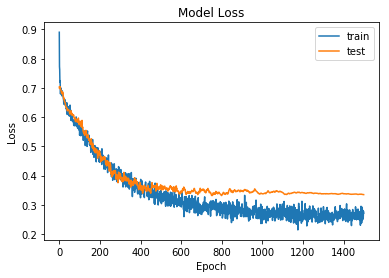

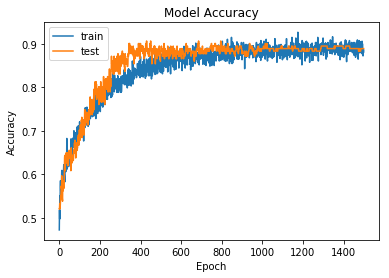

In [13]:
# Print charts to indicate performance
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()